In [1]:
# =============================================================================
# Copyright (c) 2020 NVIDIA. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =============================================================================

import torch

from nemo.backends.pytorch.tutorials import MSELoss, RealFunctionDataLayer, TaylorNet
from nemo.core import (
    DeviceType,
    EvaluatorCallback,
    NeuralGraph,
    NeuralModuleFactory,
    OperationMode,
    SimpleLossLoggerCallback,
)
from nemo.utils import logging
from nemo.utils.app_state import AppState

# Create Neural(Module)Factory, use CPU.
nf = NeuralModuleFactory(placement=DeviceType.CPU)

### Introduction to Neural Graphs (NGs) 

The Neural Graph is a high-level abstract concept empowering the users to build graphs consisting of many, interconnected Neural Modules. A user in his/her application can build any number of graphs, potentially spanning over the same modules. Once defined, graphs can be exported/saved and imported/restored in other application(s).

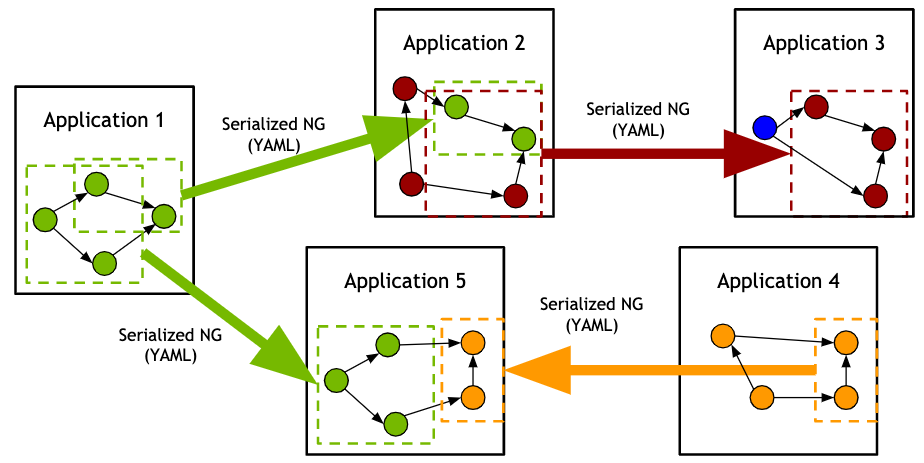

The import/export/save/restore options combined with the lightweight API make Neural Graphs a perfect tool for rapid prototyping and experimentation.




### Tutorial I: The basic functionality

In this first part of the Neural Graphs (NGs) tutorial we will focus on a simple example: training TaylorNet module to approximate a sine wave function. We will build a simple "model graph" and show how we can nest it into another graphs.

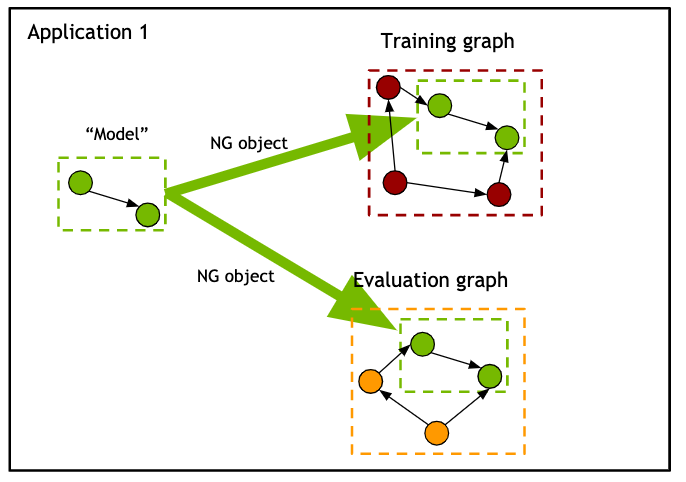

#### This part covers the following:
 * how to create a Neural Graph
 * how to bind NG inputs and outpus
 * how to nest one graph (representing the our trained model) into training and validation graphs


In [2]:
# Instantiate the necessary neural modules.
dl_training = RealFunctionDataLayer(n=10000, batch_size=32)
dl_validation = RealFunctionDataLayer(n=10000, batch_size=32)
tn = TaylorNet(dim=4)
loss = MSELoss()

In [3]:
# Build the training graph.
with NeuralGraph(operation_mode=OperationMode.both) as trainable_module:
    # Create bound input port by copying the definition from input port "x" of TaylorNet.
    trainable_module.inputs["input"] = tn.input_ports["x"]
    # Bind the "x" input, so that "x" of graph will "lead" to input port "x" of TaylorNet.
    _ = tn(x=trainable_module.inputs["input"])
    # Add the module for the second time, also binding the port.
    _ = tn(x=trainable_module.inputs["input"])
    # All outputs will be bound by default.
    
# Let us see what the graph looks like.
logging.info(trainable_module.summary())

[NeMo I 2020-05-17 13:30:38 <ipython-input-3-c229e9ccc94d>:12] 
    The `neuralgraph0` Neural Graph [OperationMode.both]:
     * Modules (1):
        * `taylornet0` (TaylorNet)
     * Steps (2):
        0. taylornet0
        1. taylornet0
     * Connections (0):
     * Graph Inputs (2):
        * input->0.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
        * input->1.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Outputs (2, default):
        * 0.taylornet0.y_pred->y_pred | axes: (batch, dimension);  elements_type: ChannelType
        * 1.taylornet0.y_pred->1_taylornet0_y_pred | axes: (batch, dimension);  elements_type: ChannelType


In [4]:
# And how about an arbitrary graph with a loop?
with NeuralGraph(operation_mode=OperationMode.both) as trainable_module:
    # As this time we decided to stay with the original port name "x", we can use the "default input binding".
    embeddings = tn(x=trainable_module)
    # Now create a loop and pass them back as inputs to TaylorNet instance.
    prediction = tn(x=embeddings)
    # Moreover, we are interested only in the second output, so we must "manually bind" it.
    trainable_module.outputs["prediction"] = prediction
    
# Ok, let us see what the graph looks like now.
logging.info(trainable_module.summary())

[NeMo I 2020-05-17 13:30:38 <ipython-input-4-ee02e839bf21>:11] 
    The `neuralgraph1` Neural Graph [OperationMode.both]:
     * Modules (1):
        * `taylornet0` (TaylorNet)
     * Steps (2):
        0. taylornet0
        1. taylornet0
     * Connections (1):
        * 0.taylornet0.y_pred->1.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Inputs (1):
        * x->0.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Outputs (1, manual):
        * 1.taylornet0.y_pred->prediction | axes: (batch, dimension);  elements_type: ChannelType


In [5]:
# Still, let's connect the graph in a different way.
with NeuralGraph(operation_mode=OperationMode.both) as trainable_module:
    # As this time we decided to stay with the original port name "x", we can use the "default input binding".
    prediction = tn(x=trainable_module)
    # Moreover, we are interested only in the second output, so we must "manually bind" it.
    trainable_module.outputs["prediction"] = prediction
    
# Ok, let us see what the graph looks like now.
logging.info(trainable_module.summary())

[NeMo I 2020-05-17 13:30:38 <ipython-input-5-d46340b38f87>:9] 
    The `neuralgraph0` Neural Graph [OperationMode.both]:
     * Modules (1):
        * `taylornet0` (TaylorNet)
     * Steps (1):
        0. taylornet0
     * Connections (0):
     * Graph Inputs (1):
        * x->0.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Outputs (1, manual):
        * 0.taylornet0.y_pred->prediction | axes: (batch, dimension);  elements_type: ChannelType


In [6]:
# Let us compose the training graph.
with NeuralGraph(operation_mode=OperationMode.training) as training_graph:
    # Take outputs from the training DL.
    x, t = dl_training()
    # Pass them to the trainable module.
    p = trainable_module(x=x)
    # Pass both of them to loss.
    lss = loss(predictions=p, target=t)
    # We will use "loss" as output during training, so we must "manually bind" it.
    training_graph.outputs["loss"] = lss
    
# Ok, let us see what the graph looks like now.
logging.info(training_graph.summary())
# In the following plaese note that:
#  * during nesting the graph was flattened - 3 modules, 4 steps
#  * the input passed to "trainable_module" bound input port were passed to the actual input of TaylorNet
#  * the graph is VALID, i.e. there are no inputs that are bound and there is a single datalayer
# So in short: we can execute it!

[NeMo I 2020-05-17 13:30:38 <ipython-input-6-12973682e332>:13] 
    The `neuralgraph2` Neural Graph [OperationMode.training]:
     * Modules (3):
        * `realfunctiondatalayer0` (RealFunctionDataLayer)
        * `taylornet0` (TaylorNet)
        * `mseloss0` (MSELoss)
     * Steps (3):
        0. realfunctiondatalayer0
        1. taylornet0
        2. mseloss0
     * Connections (3):
        * 0.realfunctiondatalayer0.x->1.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
        * 0.realfunctiondatalayer0.y->2.mseloss0.target | axes: (batch, dimension);  elements_type: LabelsType
        * 1.taylornet0.y_pred->2.mseloss0.predictions | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Inputs (0):
     * Graph Outputs (1, manual):
        * 2.mseloss0.loss->loss | axes: None;  elements_type: LossType


In [7]:
# Let us compose the validation graph.
with NeuralGraph(operation_mode=OperationMode.evaluation) as validation_graph:
    # Take outputs from the training DL.
    x_valid, t_valid = dl_validation()
    # Pass them to the trainable module.
    p_valid = trainable_module(x=x_valid)
    loss_valid = loss(predictions=p_valid, target=t_valid)

# Ok, let us see what the graph looks like now.
logging.info(validation_graph.summary())

[NeMo I 2020-05-17 13:30:38 <ipython-input-7-c324cdb0c6a7>:10] 
    The `neuralgraph3` Neural Graph [OperationMode.evaluation]:
     * Modules (3):
        * `realfunctiondatalayer1` (RealFunctionDataLayer)
        * `taylornet0` (TaylorNet)
        * `mseloss0` (MSELoss)
     * Steps (3):
        0. realfunctiondatalayer1
        1. taylornet0
        2. mseloss0
     * Connections (3):
        * 0.realfunctiondatalayer1.x->1.taylornet0.x | axes: (batch, dimension);  elements_type: ChannelType
        * 0.realfunctiondatalayer1.y->2.mseloss0.target | axes: (batch, dimension);  elements_type: LabelsType
        * 1.taylornet0.y_pred->2.mseloss0.predictions | axes: (batch, dimension);  elements_type: ChannelType
     * Graph Inputs (0):
     * Graph Outputs (4, default):
        * 0.realfunctiondatalayer1.x->x | axes: (batch, dimension);  elements_type: ChannelType
        * 0.realfunctiondatalayer1.y->y | axes: (batch, dimension);  elements_type: LabelsType
        * 1.taylornet0.y_pre

In [8]:
# Create training callback logging loss to console.
train_callback = SimpleLossLoggerCallback(
    tensors=[lss], print_func=lambda x: logging.info(f'Train Loss: {str(x[0].item())}')
)

# Create evaluator callback logging/aggregating the validation loss to console.
def batch_loss_per_batch_callback(tensors, global_vars):
    if "batch_loss" not in global_vars.keys():
        global_vars["batch_loss"] = []
    for key, value in tensors.items():
        if key.startswith("loss"):
            global_vars["batch_loss"].append(torch.mean(torch.stack(value)))


def batch_loss_epoch_finished_callback(global_vars):
    epoch_loss = torch.max(torch.tensor(global_vars["batch_loss"]))
    print("Evaluation Loss: {0}".format(epoch_loss))
    return dict({"Evaluation Loss": epoch_loss})


eval_callback = EvaluatorCallback(
    eval_tensors=[loss_valid],
    user_iter_callback=batch_loss_per_batch_callback,
    user_epochs_done_callback=batch_loss_epoch_finished_callback,
    eval_step=100,
)

In [9]:
# Invoke the "train" action.
nf.reset_trainer() # I do not understand why do I have to "reset the trainer" when calling train() function again :]
nf.train(
    training_graph=training_graph,
    callbacks=[train_callback, eval_callback],
    optimization_params={"num_epochs": 3, "lr": 0.0003},
    optimizer="sgd",
)

[NeMo I 2020-05-17 13:30:38 callbacks:187] Starting .....
[NeMo I 2020-05-17 13:30:38 callbacks:199] Starting epoch 0
[NeMo I 2020-05-17 13:30:38 callbacks:224] Step: 0
[NeMo I 2020-05-17 13:30:38 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 133.73252868652344
[NeMo I 2020-05-17 13:30:38 callbacks:239] Step time: 0.03032708168029785 seconds
[NeMo I 2020-05-17 13:30:38 callbacks:445] Doing Evaluation ..............................
Evaluation Loss: 56.89524459838867
[NeMo I 2020-05-17 13:30:38 callbacks:450] Evaluation time: 0.2007582187652588 seconds
[NeMo I 2020-05-17 13:30:38 callbacks:224] Step: 25
[NeMo I 2020-05-17 13:30:38 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 1.673933982849121
[NeMo I 2020-05-17 13:30:38 callbacks:239] Step time: 0.0016808509826660156 seconds
[NeMo I 2020-05-17 13:30:38 callbacks:224] Step: 50
[NeMo I 2020-05-17 13:30:38 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 0.45499667525291443
[NeMo I 2020-05-17 13:30:38 callbacks:239] Step time: 0.0017220973968

[NeMo I 2020-05-17 13:30:40 callbacks:239] Step time: 0.0018208026885986328 seconds
[NeMo I 2020-05-17 13:30:40 callbacks:224] Step: 700
[NeMo I 2020-05-17 13:30:40 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 0.025430599227547646
[NeMo I 2020-05-17 13:30:40 callbacks:239] Step time: 0.002196073532104492 seconds
[NeMo I 2020-05-17 13:30:40 callbacks:445] Doing Evaluation ..............................
Evaluation Loss: 0.05461966246366501
[NeMo I 2020-05-17 13:30:40 callbacks:450] Evaluation time: 0.1993720531463623 seconds
[NeMo I 2020-05-17 13:30:40 callbacks:224] Step: 725
[NeMo I 2020-05-17 13:30:40 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 0.049973636865615845
[NeMo I 2020-05-17 13:30:40 callbacks:239] Step time: 0.0016949176788330078 seconds
[NeMo I 2020-05-17 13:30:40 callbacks:224] Step: 750
[NeMo I 2020-05-17 13:30:40 <ipython-input-8-a0a2a4134ba3>:3] Train Loss: 0.04071071371436119
[NeMo I 2020-05-17 13:30:41 callbacks:239] Step time: 0.001750946044921875 seconds
[NeMo I 